In [1]:
%matplotlib inline

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from dataclasses import dataclass
from functools import reduce
from scipy.io import wavfile
from scipy.signal import decimate, hilbert
from dsp import fm_demod
from utils import lowpass, plot_signals, welch

# NOAA satellite signal decoding
Photos from the satellite are transferred using APT (Automatic Picture Transmission) protocol. APT data bytes are used as an 256-valued signal to modulate amplitude of 2400Hz subcarrier. This signal is then used to modulate frequency of 137MHz carrier.

### Read and inspect the data
Short signal (7 lines) source: [Signal Identification Guide](https://www.sigidwiki.com/wiki/File:APT_IQ.zip)

Long signal (?) source: [SDR Angel](http://www.sdrangel.org/iq-files/)

In [33]:
# sample_rate, iq_samples = wavfile.read('data/APT IQ.wav')
sample_rate, iq_samples = wavfile.read('data/apt/apt.2021-11-27T10_42_34_142.wav')

/tmp/ipykernel_48745/746902544.py:2: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, iq_samples = wavfile.read('data/apt/apt.2021-11-27T10_42_34_142.wav')


In [34]:
sample_rate

62500

In [35]:
iq_samples.shape

(34338313, 2)

In [39]:
print(f'Recording duration is {(iq_samples.shape[0] / sample_rate) / 60} minutes.')

Recording duration is 9.156883466666667 minutes.


In [40]:
iq_samples = iq_samples[:, 0] + 1j * iq_samples[:, 1]

/home/jakub/projects/SDR/SDR/env/lib/python3.10/site-packages/scipy/signal/_spectral_py.py:454: UserWarning: Input data is complex, switching to return_onesided=False
  freqs, Pxx = csd(x, x, fs=fs, window=window, nperseg=nperseg,


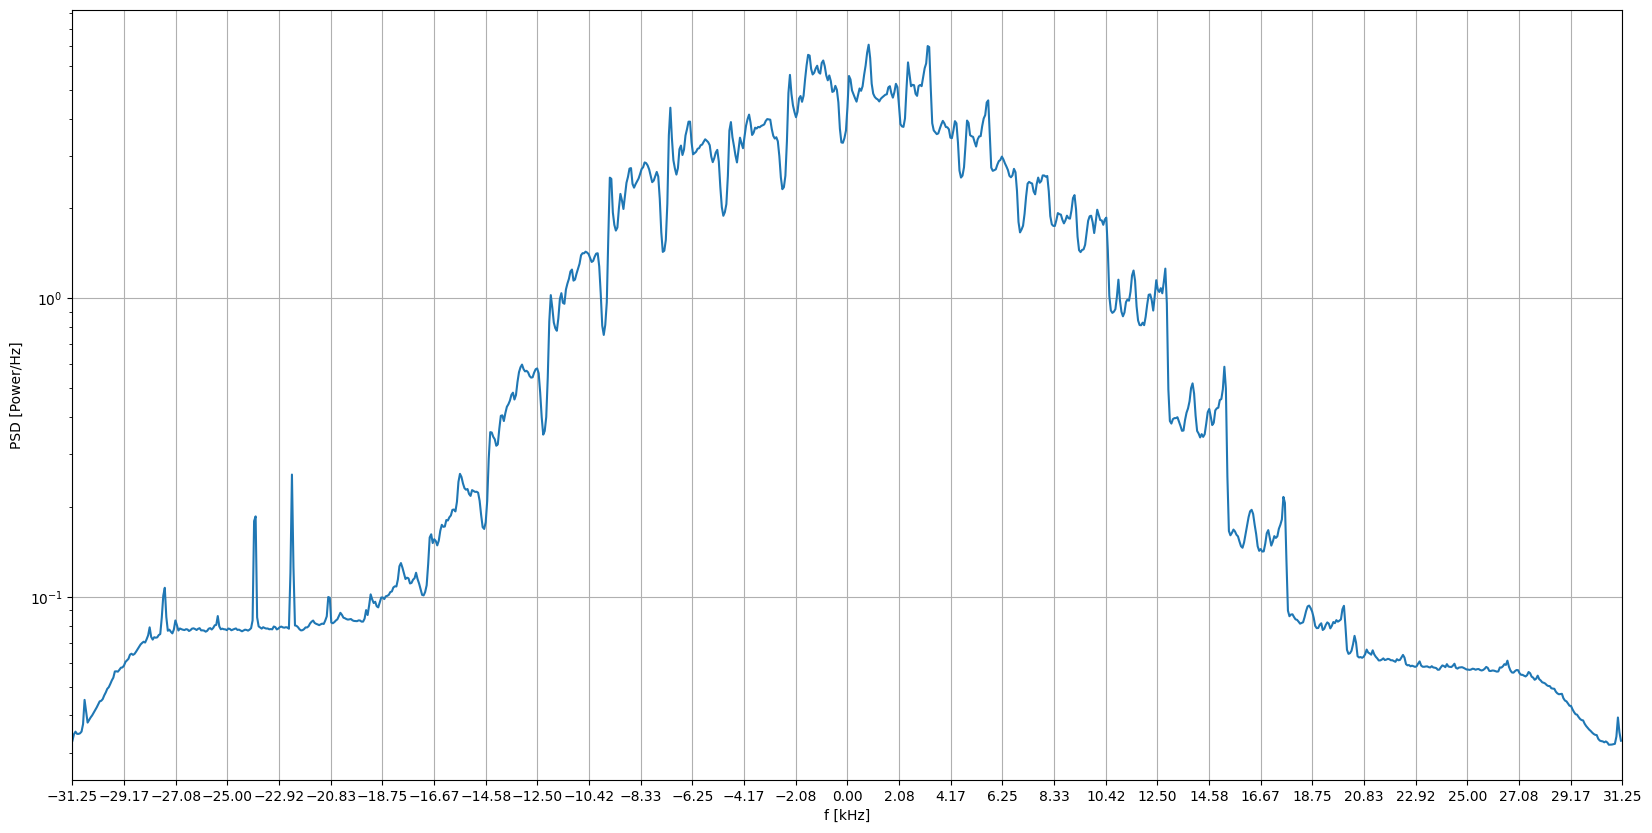

In [41]:
welch(iq_samples, sample_rate)

Our data is already downconverted to baseband.

### Demodulate FM signal

In [42]:
apt_signal = fm_demod(iq_samples)

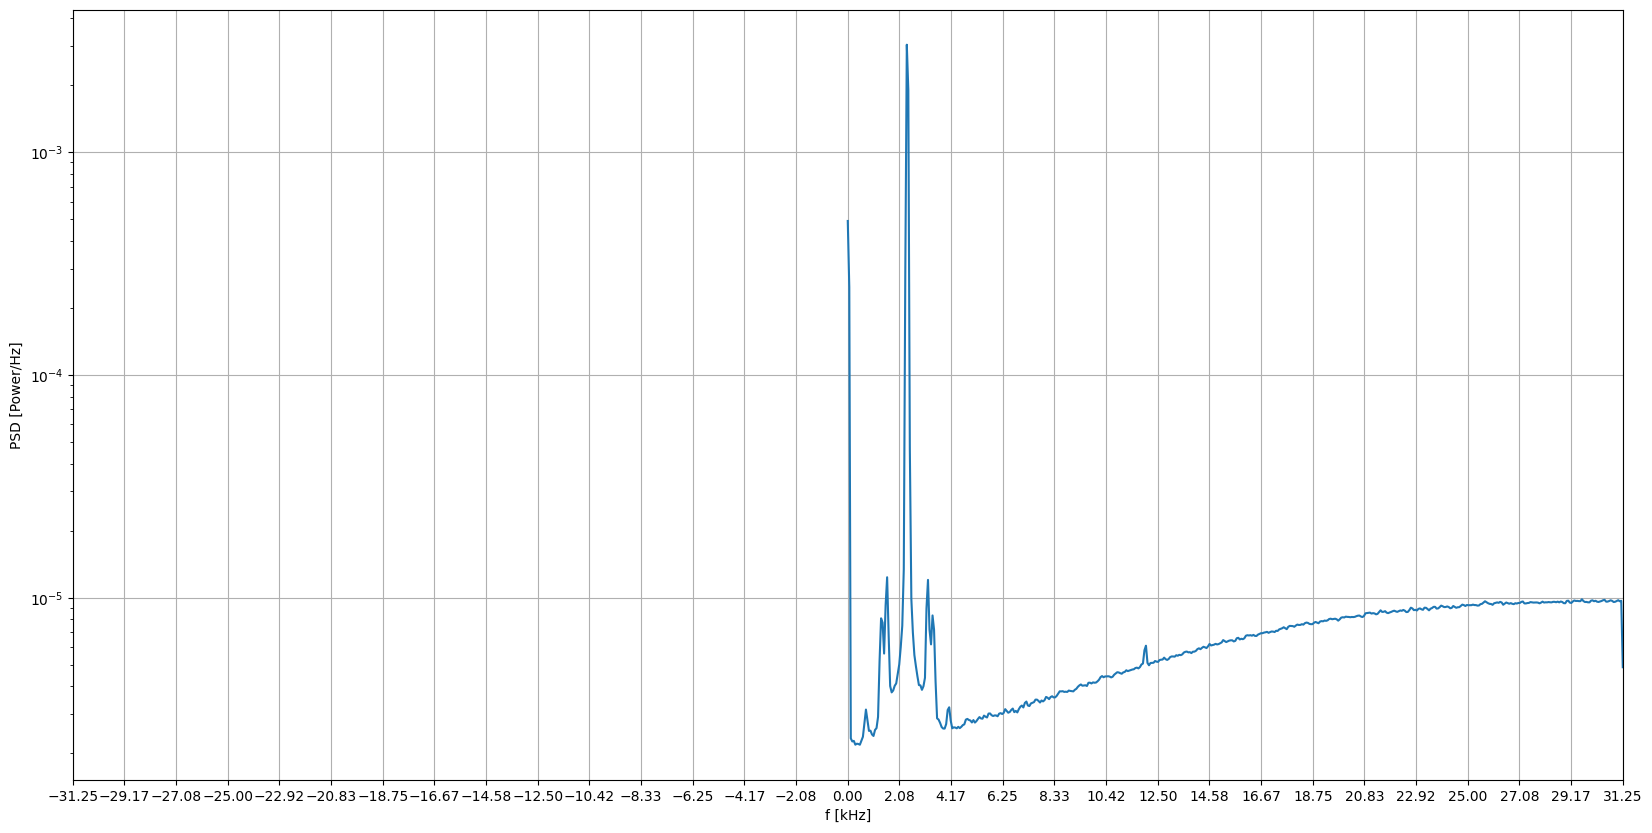

In [43]:
welch(apt_signal, sample_rate)

Sample rate after decimation: 3906 samples/sec


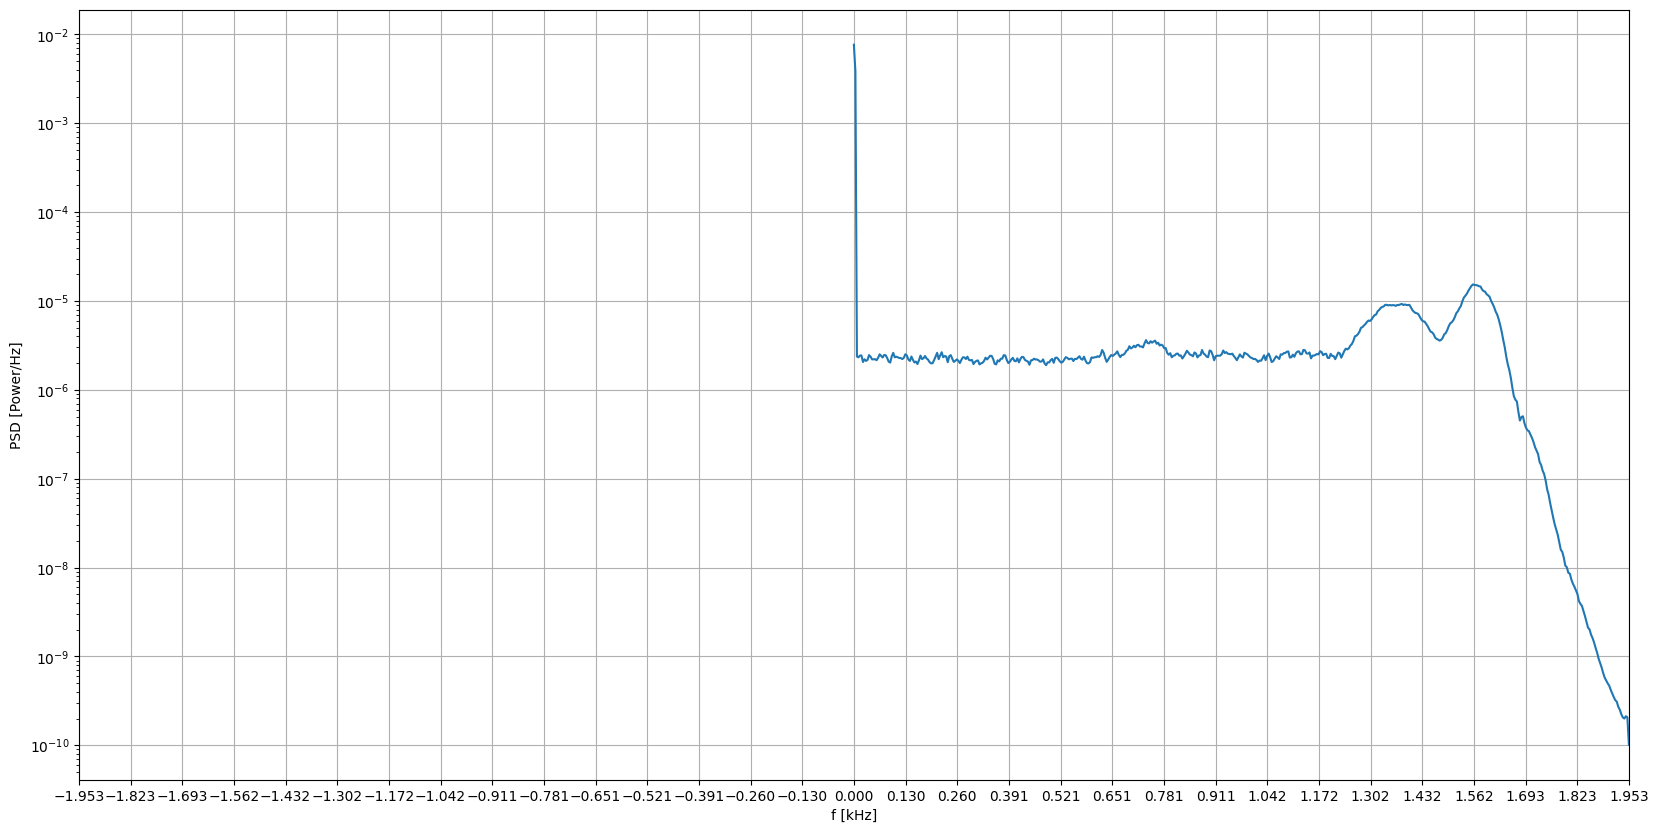

In [44]:
sample_rate_dec = int(sample_rate / 16)
print(f'Sample rate after decimation: {sample_rate_dec} samples/sec')
apt_signal_dec = decimate(apt_signal, 16)
welch(apt_signal_dec, sample_rate_dec)

### Inspect AM signal

In [45]:
f_subcarrier = 2400
line_length = 2080
lines_per_sec = 2
symbol_rate = line_length * lines_per_sec
samples_per_symbol = sample_rate_dec / symbol_rate
print(f'Symbol rate: {symbol_rate} symbols/s\n{samples_per_symbol} samples per symbol')

Symbol rate: 4160 symbols/s
0.9389423076923077 samples per symbol


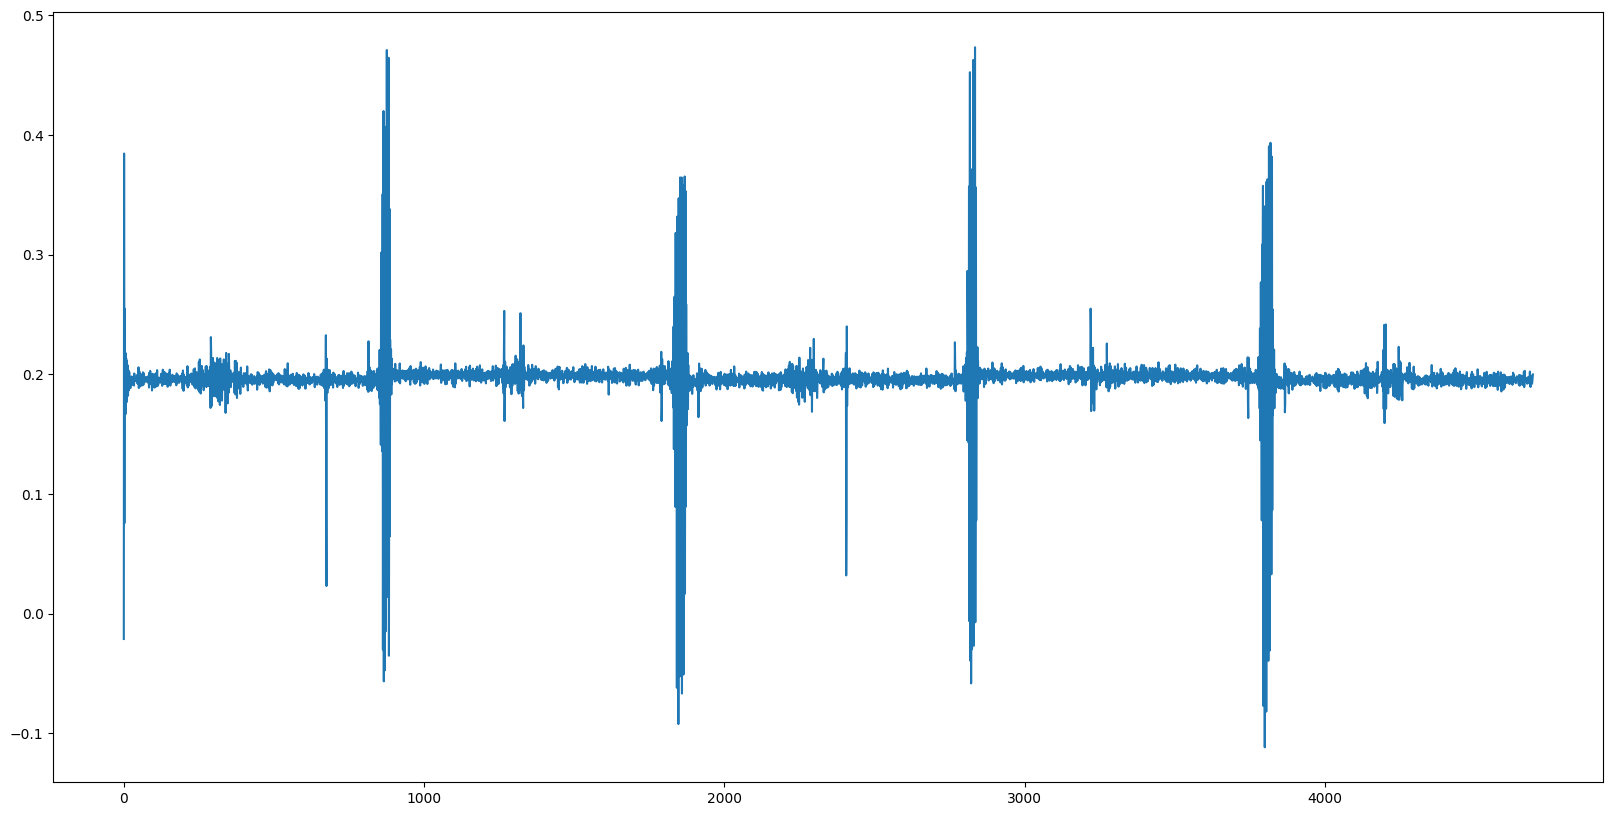

In [49]:
plot_signals([apt_signal_dec], start=0, width=int(5000 * samples_per_symbol))

### Demodulate AM signal
There are multiple methods. Let's try with square law demodulation first.

In [50]:
def am_demod_square(samples, f_modulation, sample_rate):
    return 2 * np.sqrt(lowpass(samples ** 2, sample_rate, 2 * f_modulation))


def am_demod_fast(samples, f_carrier, sample_rate):
    phi = 2 * np.pi * f_carrier / sample_rate
    demodulated = np.sqrt(samples[:-1] ** 2 + samples[1:] ** 2 - samples[:-1] * samples[1:] * 2 * np.cos(phi)) / np.sin(phi)
    return np.insert(demodulated, 0, 0)

In [51]:
apt_data_square_demod = am_demod_square(apt_signal_dec, symbol_rate, sample_rate)

/tmp/ipykernel_48745/3704837597.py:2: RuntimeWarning: invalid value encountered in sqrt
  return 2 * np.sqrt(lowpass(samples ** 2, sample_rate, 2 * f_modulation))


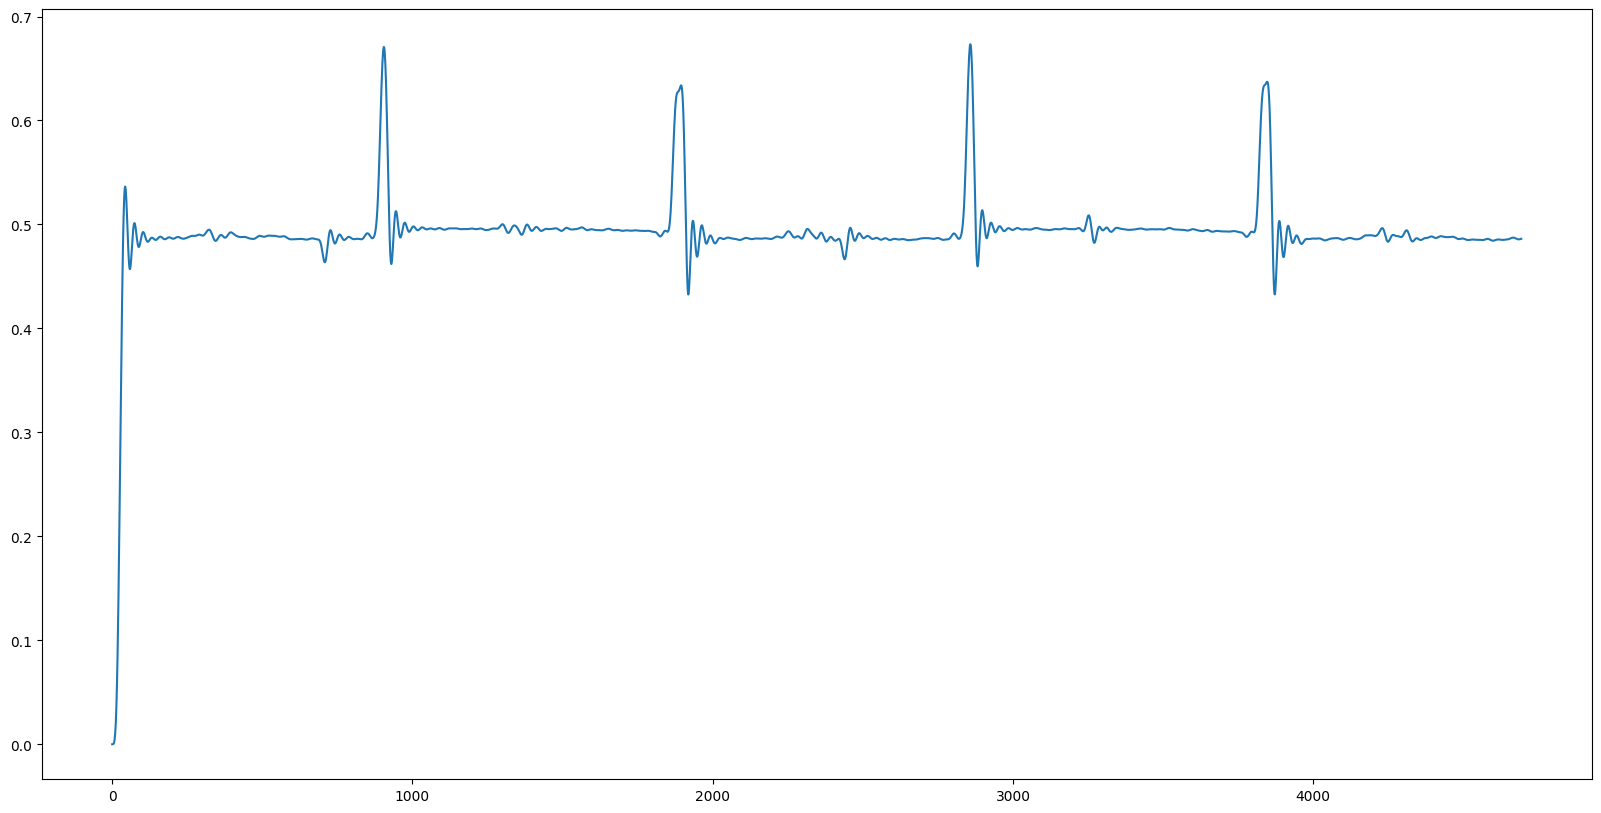

In [57]:
plot_signals([apt_data_square_demod], start=0, width=int(5000 * samples_per_symbol))

In [58]:
apt_data_fast_demod = am_demod_fast(apt_signal_dec, f_subcarrier, sample_rate)

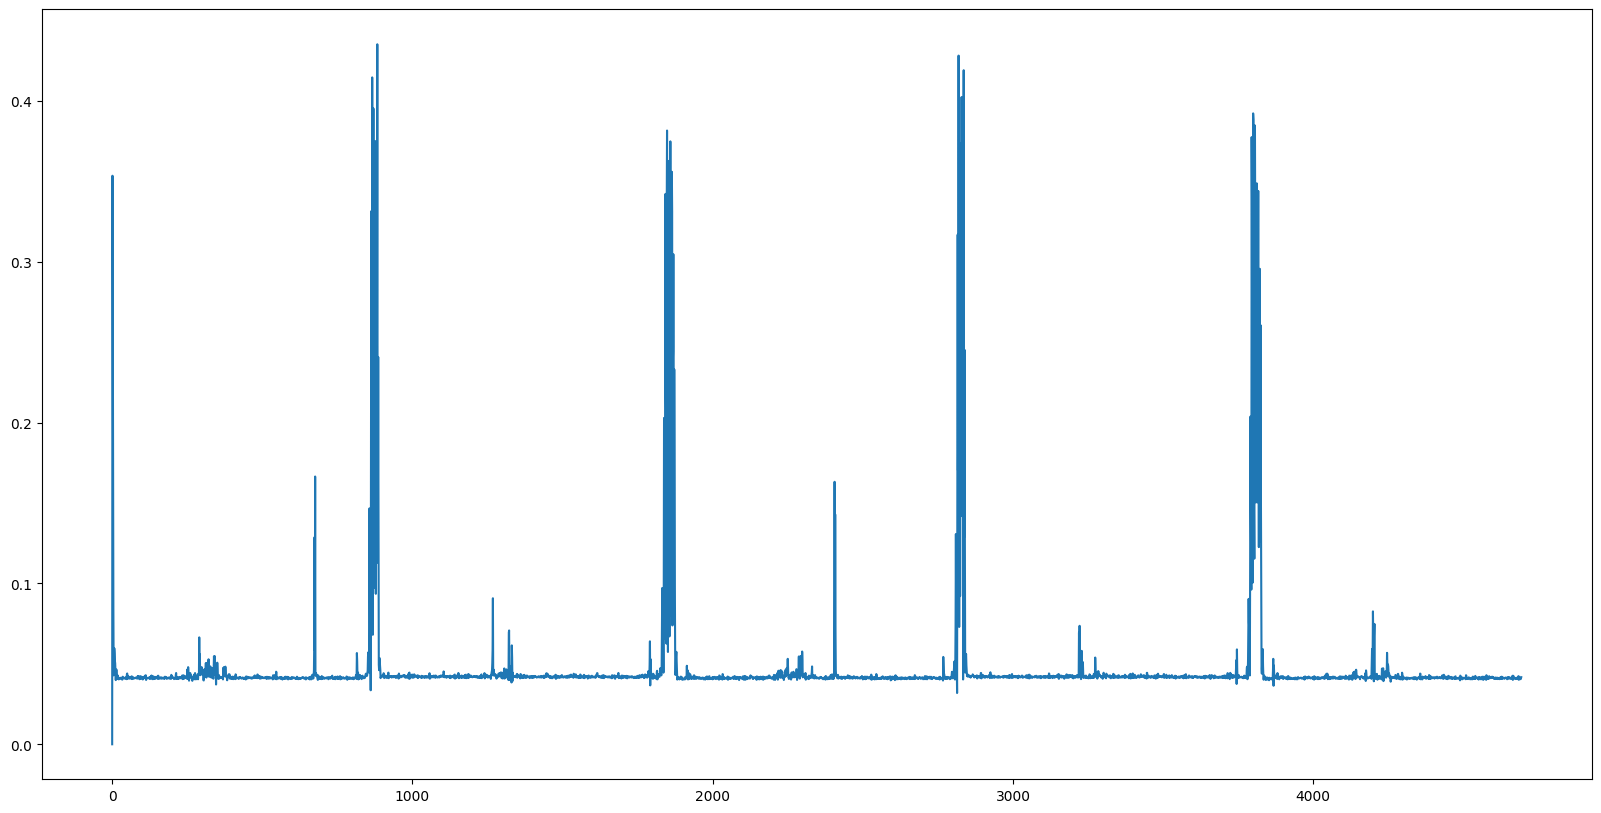

In [60]:
plot_signals([apt_data_fast_demod], start=0, width=int(5000 * samples_per_symbol))

To be honest I don't know if one of these methods is preferrable. Let's start with square demodulated signal just because it's smoother (low-pass filtered already).

### Find line beginnings
Data frame structure described [here](https://www.sigidwiki.com/wiki/Automatic_Picture_Transmission_(APT)).

In [61]:
def line_start_correlations(signal, samples_per_symbol):
    sync_a = np.array(list(map(lambda b: int(b), '000011001100110011001100110011000000000')))
    
    i = 0
    correlations = []
    while i + len(sync_a) * samples_per_symbol < len(signal):
        j = i
        potential_line = []
        
        for _ in range(len(sync_a)):
            potential_line.append(signal[int(j)])
            j += samples_per_symbol
    
        correlations.append(reduce(lambda acc, b: acc + b[0] * b[1], zip(potential_line, sync_a), 0))
        i += 1
    
    return np.array(correlations)

In [62]:
correlations = line_start_correlations(apt_data_square_demod, samples_per_symbol)

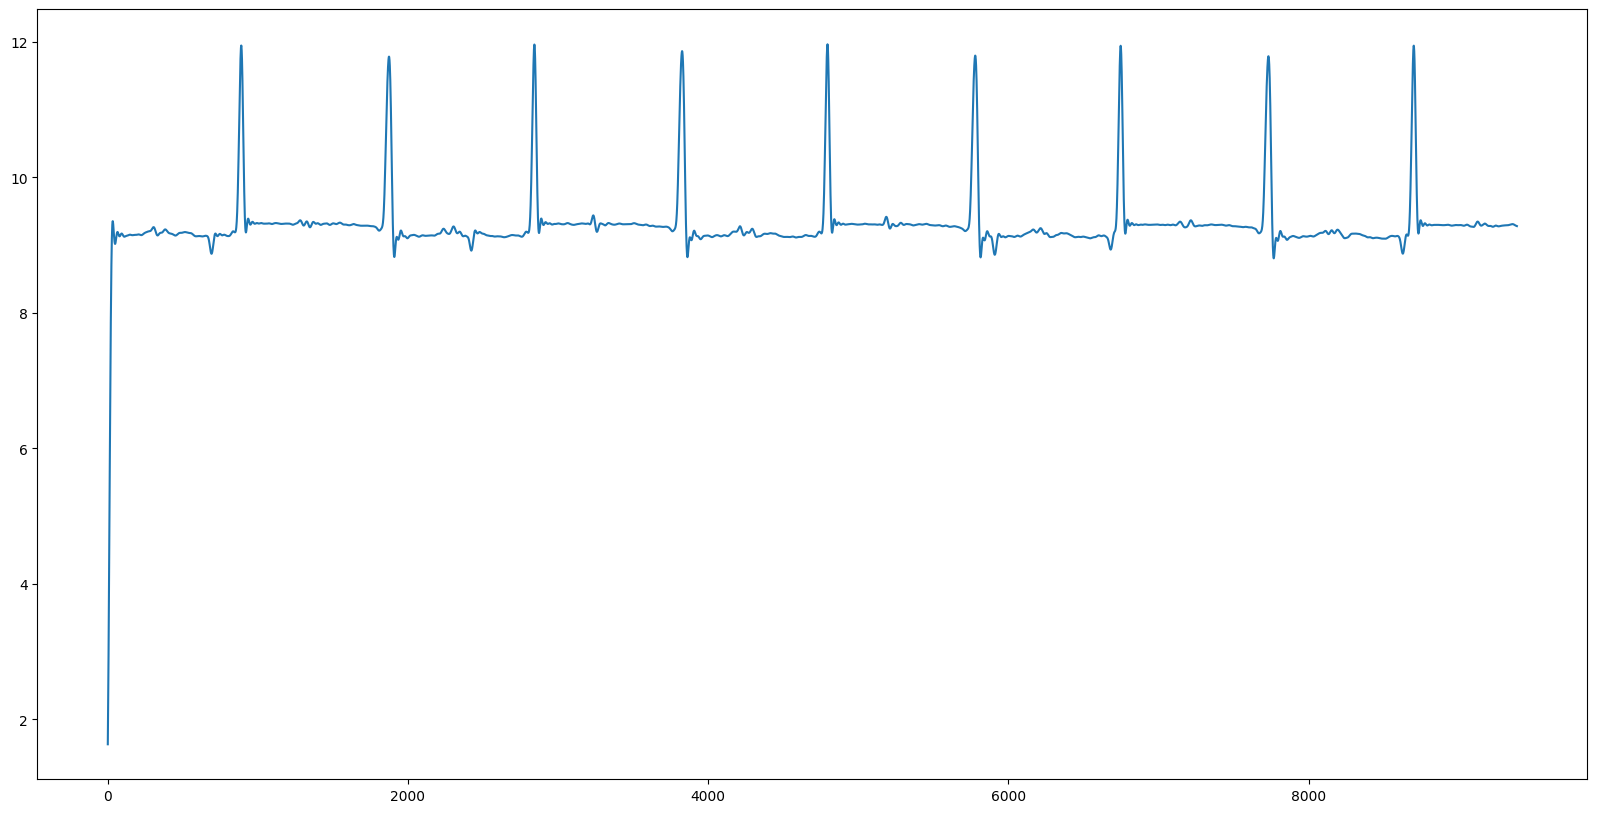

In [63]:
def plot_correlations(correlations, start=0, width=None, max_indexes=None):
    fig, ax = plt.subplots()
    fig.set_size_inches((20, 10))
    ax.plot(correlations[start:-1 if width is None else start + width])
    if max_indexes is not None:
        indexes_on_plot = list(filter(lambda idx: idx >= start and (True if width is None else idx <= start + width), max_indexes))
        ax.plot(indexes_on_plot, [correlations[idx] for idx in indexes_on_plot], '*')

plot_correlations(correlations, width=int(10000 * samples_per_symbol))

There is hope for us! We have clear periodic maximum. Let's find indexes of these maximum correlations and we can attempt to decode the lines!

In [109]:
def find_line_starts(correlations, samples_per_symbol):
    max_correlation_indexes = []
    frame_length_samples = int(samples_per_symbol * line_length)
    
    for i in range(0, len(correlations), frame_length_samples):
        max_correlation_indexes.append(i + np.nanargmax(correlations[i:i + frame_length_samples]))
    return np.array(max_correlation_indexes)

In [110]:
line_starts = find_line_starts(correlations, samples_per_symbol)

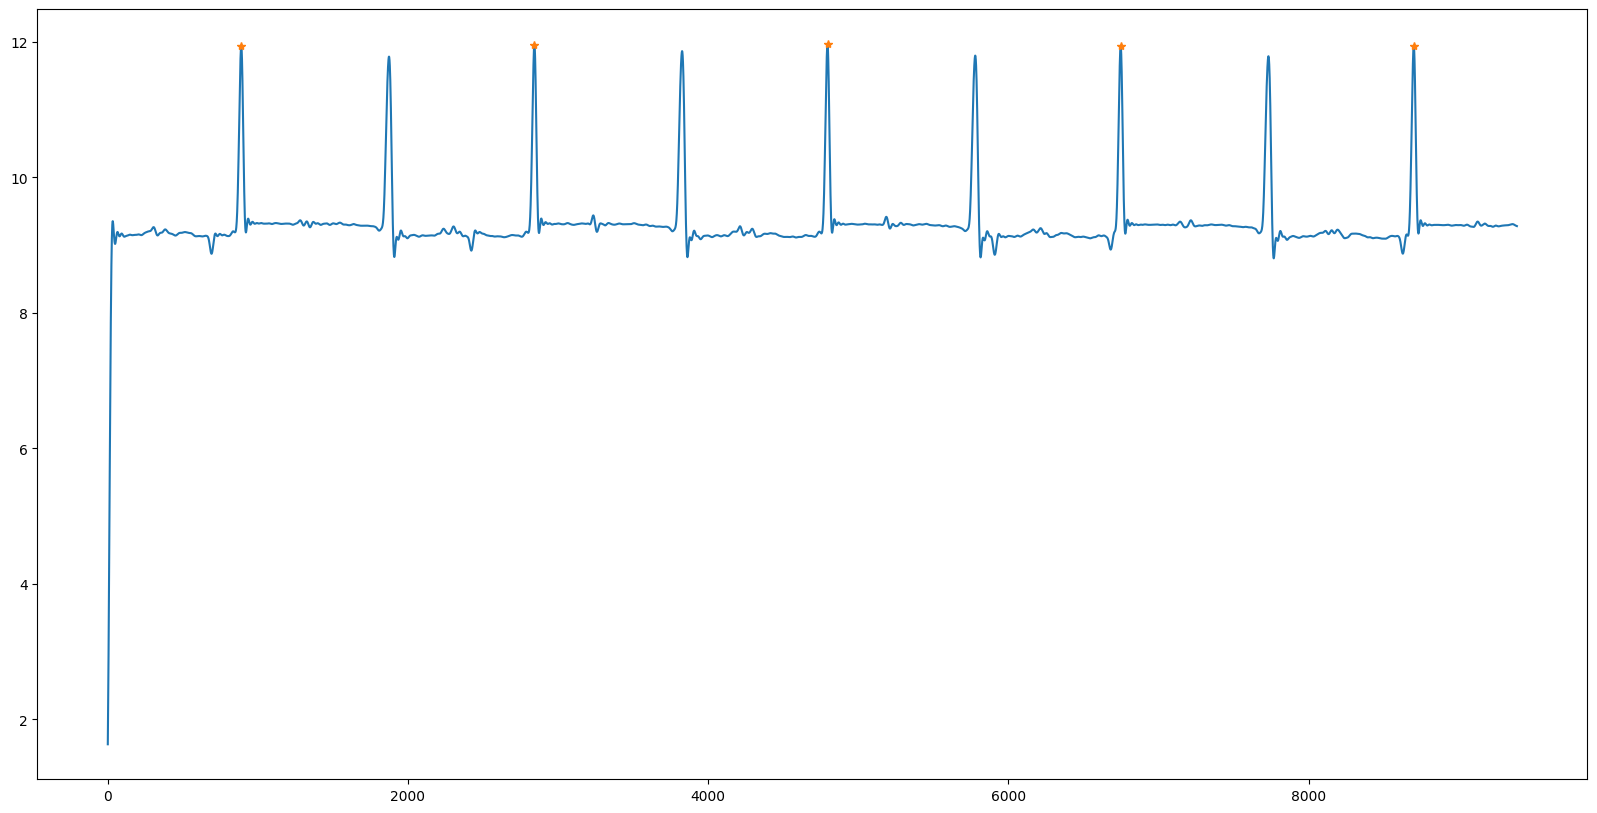

In [111]:
plot_correlations(correlations, max_indexes=line_starts, width=int(10000 * samples_per_symbol))

That looks goooood.

In [67]:
print(f'Found {len(line_starts)} data lines in input_data.')

Found 1099 data lines in input_data.


A full APT frame is 128 lines. Also, [this source](https://sourceforge.isae.fr/projects/weather-images-of-noaa-satellites/wiki/Apt_) says that full image takes around 12 minutes (!) to be transmitted, so full image is around 1440 pixels high and 990 pixels wide.

### Line decoding

In [78]:
@dataclass
class LineData:
    space_a: np.ndarray[np.byte]
    image_a: np.ndarray[np.byte]
    telemetry_a: np.ndarray[np.byte]

    space_b: np.ndarray[np.byte]
    image_b: np.ndarray[np.byte]
    telemetry_b: np.ndarray[np.byte]


def decode_line(data, start_idx, samples_per_symbol):
    class LineIncompleteError(Exception):
        pass

    
    def get_chunk(n_symbols):
        nonlocal start_idx
        i = start_idx
        symbols = []
        
        while i < len(data) and len(symbols) < n_symbols:
            symbols.append(data[int(i)])
            i += samples_per_symbol

        if len(symbols) < n_symbols:
            raise LineIncompleteError()

        start_idx = i
        return np.array(symbols)
  
    # skip sync
    try:
        _, space_a, image_a, telemetry_a = get_chunk(39), get_chunk(47), get_chunk(909), get_chunk(45)
        _, space_b, image_b, telemetry_b = get_chunk(39), get_chunk(47), get_chunk(909), get_chunk(45)
        return LineData(space_a, image_a, telemetry_a, space_b, image_b, telemetry_b)
    except LineIncompleteError:
        return None

In [79]:
lines = list(filter(lambda x: x, [decode_line(apt_data_square_demod, idx, samples_per_symbol) for idx in line_starts]))

In [80]:
print(f'{len(lines)} lines decoded')

1098 lines decoded


### Lines to frames
We need to find frame start by looking at *wedges* in telemetry data and finding lowest intensity wedge as described [here](https://www.sigidwiki.com/wiki/Automatic_Picture_Transmission_(APT)).

In [81]:
# TODO: find frame start, collect lines into frames
partial_frame_lines = lines

### Frames to image
Wedge data must be used to quantize pixel values.

In [87]:
lines[0].space_a

array([0.64451594, 0.63499474, 0.62778944, 0.62295946, 0.62047025,
       0.62019551, 0.62192677, 0.62538887, 0.6302592 , 0.63618824,
       0.64281902, 0.64281902, 0.6498043 , 0.65682023, 0.66357678,
       0.66982476, 0.67536017, 0.68002623, 0.68371363, 0.68635944,
       0.68794485, 0.6884921 , 0.68806066, 0.68674271, 0.68465807,
       0.68194863, 0.67877217, 0.67877217, 0.67529594, 0.67168981,
       0.66811947, 0.66473969, 0.66168806, 0.65907959, 0.65700234,
       0.65551456, 0.65464339, 0.6543853 , 0.65470816, 0.65555475,
       0.65684737, 0.65849322, 0.66039007, 0.66039007, 0.66243193,
       0.6645143 , 0.66653891])

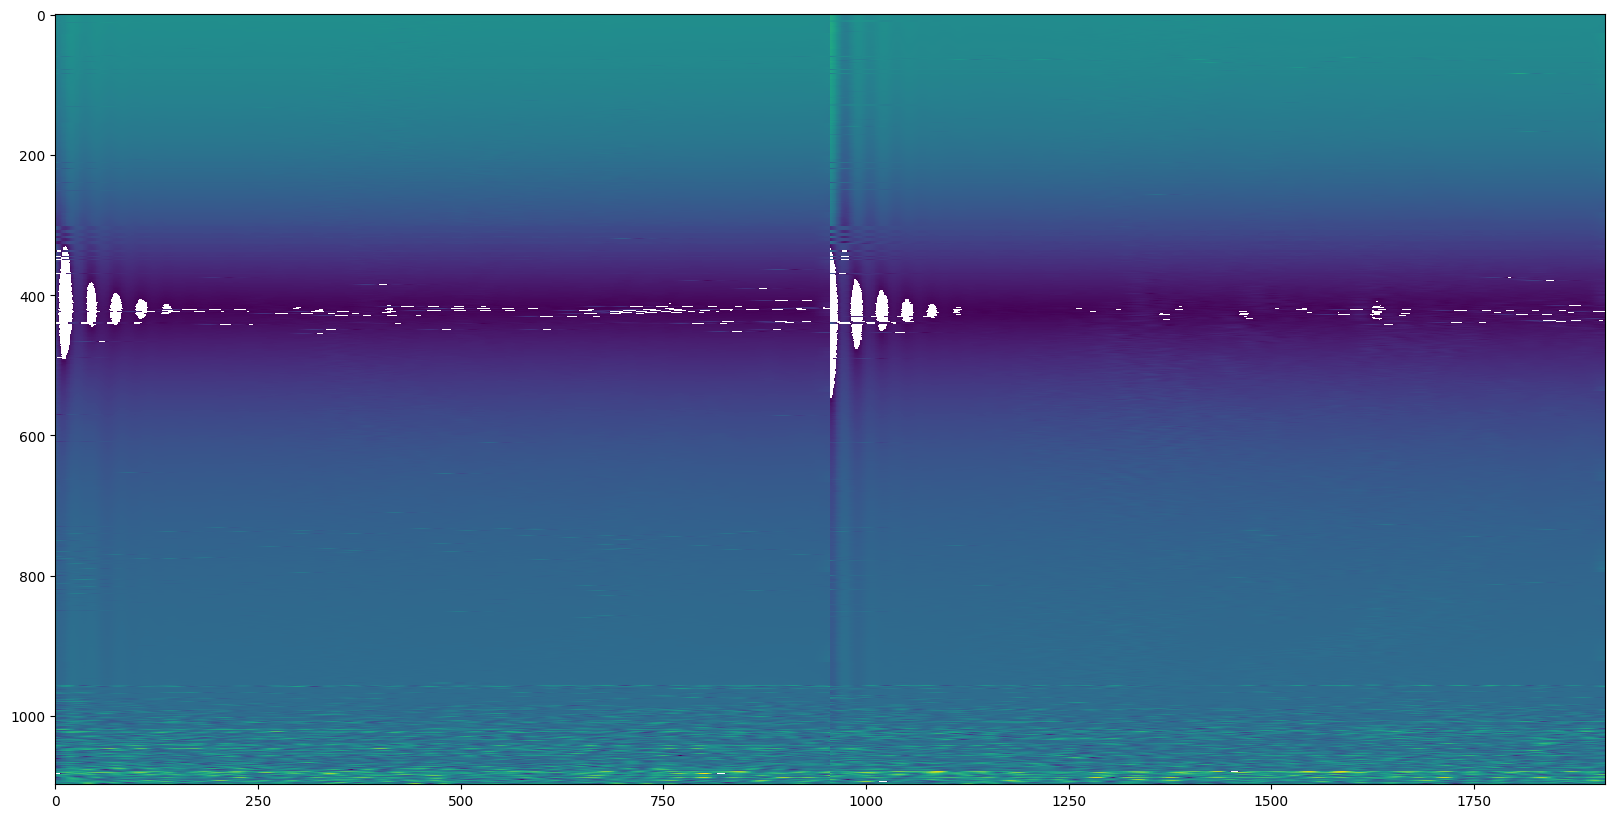

In [112]:
def display_frames_image(frame_lines):
    # TODO: use wedges to quantize
    image = np.stack([np.concatenate([line.space_a, line.image_a, line.space_b, line.image_b]) for line in frame_lines])
    plt.figure(figsize = (20,10))
    plt.imshow(image, interpolation='nearest', aspect='auto')
    plt.show()


display_frames_image(partial_frame_lines)

Well, something's not yes.